In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **exection steps:**
# ***first mount the drive for dataset ***
# ***then execute all the programs step by step***

# ***task1***

In [ ]:
# Initialize the folders with train, test and validation datasets (in "/My Drive/..." or from your local repository where you have downloaded data):

train = '/content/drive/MyDrive/dl/train'
val = '/content/drive/MyDrive/dl/val'
test = '/content/drive/MyDrive/dl/test'

# The shape of the RGB image
img_width, img_height, channels = 150, 150, 3 # you can try different sizes

# input shape
input_shape = (img_width, img_height, 3)
# position matters!
# Number_of_channels can be at the first or the last position
# in our case - "channels last"

# minibatch size
batch_size = 4
# train set size
nb_train_samples = 20000
# validation set size
nb_validation_samples = 2490
# test set size
nb_test_samples = 2500

In [ ]:
ls /content/drive/MyDrive/dl/train/dogs/ | wc -l

6360


In [ ]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

resize = transforms.Resize(size=(img_height, img_width))
trainTransforms = transforms.Compose([resize, transforms.ToTensor()])
testTransforms = transforms.Compose([resize, transforms.ToTensor()])

train_path = '/content/drive/MyDrive/dl/train/'
test_path = '/content/drive/MyDrive/dl/test/'
val_path = '/content/drive/MyDrive/dl/val'

train_data = ImageFolder(train_path, transform=trainTransforms)
test_data = ImageFolder(test_path, transform=testTransforms)
val_data = ImageFolder(val_path, transform=testTransforms)
# Setup the batch size hyperparameter
BATCH_SIZE = batch_size

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)
val_dataloader = DataLoader(val_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of val dataloader: {len(val_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7e2d29baa260>, <torch.utils.data.dataloader.DataLoader object at 0x7e2d29bab0d0>)
Length of train dataloader: 4090 batches of 4
Length of test dataloader: 625 batches of 4
Length of val dataloader: 623 batches of 4


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch


class CatsVsDogsModel(nn.Module):
    def __init__(self):
        super(CatsVsDogsModel, self).__init__()

        self.cnn_model = nn.Sequential(
            nn.Conv2d(3, 16, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.fc_model = nn.Sequential(
            nn.Linear(64 * 17 * 17, 64),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        return x

In [ ]:
import torch.optim as optim
from torch.autograd import Variable
import torch.nn as nn

# Assuming you have defined your CatsVsDogsModel class, train_dataloader, and val_dataloader

model = CatsVsDogsModel()
model = model.cuda()

criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
train_losses, val_losses = [], []
train_accuracys, val_accuracys = [], []

for epoch in range(30):  # loop over the dataset multiple times
    print("epoch", epoch)
    running_loss = 0.0
    running_corrects = 0
    count = 0

    # Training phase
    model.train()  # Set the model to training mode
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

        optimizer.zero_grad()
        outputs = model(inputs)
        labels = labels.float().unsqueeze(1)

        preds = (outputs > 0.5).float()

        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
        count += len(preds)

    # Calculate training accuracy and loss for the epoch
    train_accuracy = running_corrects / count
    train_loss = running_loss / (i + 1)
    train_losses.append(train_loss)
    train_accuracys.append(train_accuracy)


    # Validation phase
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    running_corrects = 0
    count = 0

    for i, data in enumerate(val_dataloader, 0):
        inputs, labels = data
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

        outputs = model(inputs)
        labels = labels.float().unsqueeze(1)

        preds = (outputs > 0.5).float()

        loss = criterion(outputs, labels)

        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
        count += len(preds)

    # Calculate validation accuracy and loss for the epoch
    val_accuracy = running_corrects / count
    val_loss = running_loss / (i + 1)
    val_losses.append(val_loss)
    val_accuracys.append(val_accuracy)

    # Print results in the desired format
    print(f'Epoch [{epoch + 1}/30] - loss: {train_loss:.4f} - accuracy: {train_accuracy:.4f} - val_loss: {val_loss:.4f} - val_accuracy: {val_accuracy:.4f}')

# After training, you may want to save your trained model weights:
# torch.save(model.state_dict(), 'cats_vs_dogs_model.pth')


epoch 0
Epoch [1/30] - loss: 0.6691 - accuracy: 0.6096 - val_loss: 0.7431 - val_accuracy: 0.4980
epoch 1
Epoch [2/30] - loss: 0.6499 - accuracy: 0.6221 - val_loss: 0.6743 - val_accuracy: 0.5683
epoch 2
Epoch [3/30] - loss: 0.6010 - accuracy: 0.6862 - val_loss: 0.5755 - val_accuracy: 0.6964
epoch 3
Epoch [4/30] - loss: 0.5547 - accuracy: 0.7208 - val_loss: 0.5532 - val_accuracy: 0.7116
epoch 4
Epoch [5/30] - loss: 0.5145 - accuracy: 0.7498 - val_loss: 0.5335 - val_accuracy: 0.7277
epoch 5
Epoch [6/30] - loss: 0.4727 - accuracy: 0.7779 - val_loss: 0.4702 - val_accuracy: 0.7759
epoch 6
Epoch [7/30] - loss: 0.4348 - accuracy: 0.8009 - val_loss: 0.5052 - val_accuracy: 0.7522
epoch 7
Epoch [8/30] - loss: 0.3981 - accuracy: 0.8191 - val_loss: 0.4710 - val_accuracy: 0.7755
epoch 8
Epoch [9/30] - loss: 0.3596 - accuracy: 0.8410 - val_loss: 0.4985 - val_accuracy: 0.7807
epoch 9
Epoch [10/30] - loss: 0.3181 - accuracy: 0.8603 - val_loss: 0.4815 - val_accuracy: 0.7747
epoch 10
Epoch [11/30] - loss

In [ ]:
# Assuming you have created a test dataloader for your test dataset
# test_dataloader = ...

# Set the model to evaluation mode
model.eval()

running_corrects = 0
count = 0

with torch.no_grad():  # No need to compute gradients during evaluation
    for i, data in enumerate(test_dataloader, 0):
        inputs, labels = data
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

        outputs = model(inputs)
        labels = labels.float().unsqueeze(1)

        preds = (outputs > 0.5).float()

        running_corrects += torch.sum(preds == labels.data)
        count += len(preds)

# Calculate test accuracy
test_accuracy = running_corrects / count

# Print the test accuracy
print(f'Test Accuracy: {test_accuracy:.4f}')


Test Accuracy: 0.8076


<ipython-input-15-11a5185eac15>:28: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo-" (-> marker='o'). The keyword argument will take precedence.
  axes[0, 0].plot(epochs_10, train_loss_10, 'bo-', label='Training Loss', marker='o', markersize=5)
<ipython-input-15-11a5185eac15>:29: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "ro-" (-> marker='o'). The keyword argument will take precedence.
  axes[0, 0].plot(epochs_10, validation_loss_10, 'ro-', label='Validation Loss', marker='o', markersize=5)
<ipython-input-15-11a5185eac15>:38: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo-" (-> marker='o'). The keyword argument will take precedence.
  axes[1, 0].plot(epochs_10, train_accuracy_10, 'bo-', label='Training Accuracy', marker='o', markersize=5)
<ipython-input-15-11a5185eac15>:39: UserWarning: marker is redundantly defined by the 'marker'

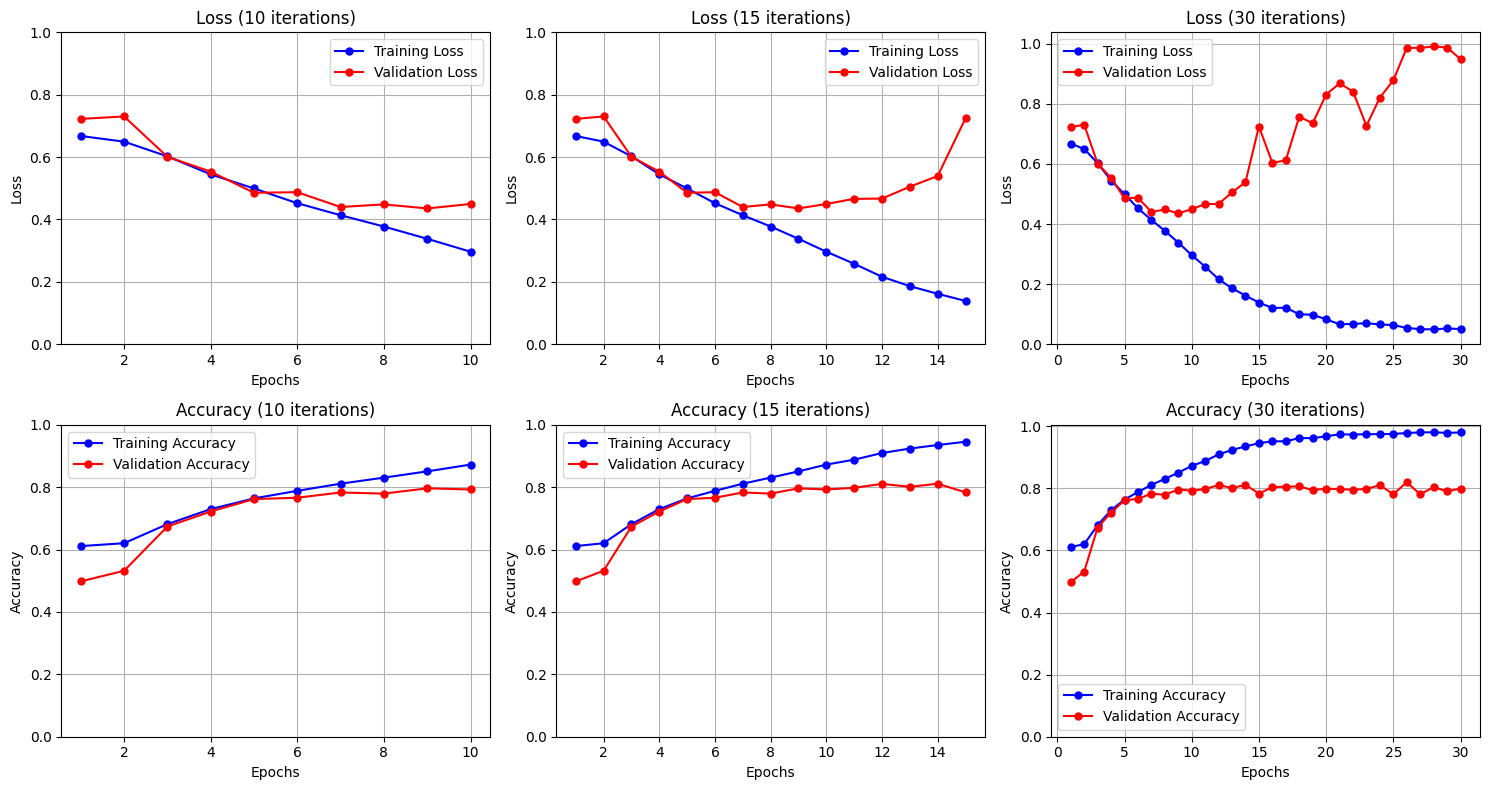

In [ ]:
import matplotlib.pyplot as plt

# Sample training and validation loss values for 10, 15, and 30 iterations (replace these with your actual data)
train_loss_10 = train_losses[:10]
validation_loss_10 = val_losses[:10]
train_loss_15 = train_losses[:15]
validation_loss_15 = val_losses[:15]
train_loss_30 = train_losses[:30]
validation_loss_30 = val_losses[:30]

# Sample training and validation accuracy values for 10, 15, and 30 iterations (replace these with your actual data)
train_accuracy_10 = train_accuracy_values[:10]
validation_accuracy_10 = val_accuracy_values[:10]
train_accuracy_15 = train_accuracy_values[:15]
validation_accuracy_15 = val_accuracy_values[:15]
train_accuracy_30 = train_accuracy_values[:30]
validation_accuracy_30 = val_accuracy_values[:30]

# Create a list of epochs for the x-axis for 10, 15, and 30 iterations
epochs_10 = list(range(1, 11))
epochs_15 = list(range(1, 16))
epochs_30 = list(range(1, 31))

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Plot the training and validation loss for 10 iterations
axes[0, 0].plot(epochs_10, train_loss_10, 'bo-', label='Training Loss', marker='o', markersize=5)
axes[0, 0].plot(epochs_10, validation_loss_10, 'ro-', label='Validation Loss', marker='o', markersize=5)
axes[0, 0].set_title('Loss (10 iterations)')
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)
axes[0, 0].set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

# Plot the training and validation accuracy for 10 iterations
axes[1, 0].plot(epochs_10, train_accuracy_10, 'bo-', label='Training Accuracy', marker='o', markersize=5)
axes[1, 0].plot(epochs_10, validation_accuracy_10, 'ro-', label='Validation Accuracy', marker='o', markersize=5)
axes[1, 0].set_title('Accuracy (10 iterations)')
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True)
axes[1, 0].set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

# Plot the training and validation loss for 15 iterations
axes[0, 1].plot(epochs_15, train_loss_15, 'bo-', label='Training Loss', marker='o', markersize=5)
axes[0, 1].plot(epochs_15, validation_loss_15, 'ro-', label='Validation Loss', marker='o', markersize=5)
axes[0, 1].set_title('Loss (15 iterations)')
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True)
axes[0, 1].set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

# Plot the training and validation accuracy for 15 iterations
axes[1, 1].plot(epochs_15, train_accuracy_15, 'bo-', label='Training Accuracy', marker='o', markersize=5)
axes[1, 1].plot(epochs_15, validation_accuracy_15, 'ro-', label='Validation Accuracy', marker='o', markersize=5)
axes[1, 1].set_title('Accuracy (15 iterations)')
axes[1, 1].set_xlabel('Epochs')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(True)
axes[1, 1].set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

# Plot the training and validation loss for 30 iterations
axes[0, 2].plot(epochs_30, train_loss_30, 'bo-', label='Training Loss', marker='o', markersize=5)
axes[0, 2].plot(epochs_30, validation_loss_30, 'ro-', label='Validation Loss', marker='o', markersize=5)
axes[0, 2].set_title('Loss (30 iterations)')
axes[0, 2].set_xlabel('Epochs')
axes[0, 2].set_ylabel('Loss')
axes[0, 2].legend()
axes[0, 2].grid(True)
axes[0, 2].set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

# Plot the training and validation accuracy for 30 iterations
axes[1, 2].plot(epochs_30, train_accuracy_30, 'bo-', label='Training Accuracy', marker='o', markersize=5)
axes[1, 2].plot(epochs_30, validation_accuracy_30, 'ro-', label='Validation Accuracy', marker='o', markersize=5)
axes[1, 2].set_title('Accuracy (30 iterations)')
axes[1, 2].set_xlabel('Epochs')
axes[1, 2].set_ylabel('Accuracy')
axes[1, 2].legend()
axes[1, 2].grid(True)
axes[1, 2].set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

plt.tight_layout()
plt.show()


**task2**



In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models

# Load pre-trained VGG16 model with weights (excluding top classification layers)
vgg_model = VGG16(weights='/content/drive/MyDrive/dl/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze the layers of the pre-trained model
for layer in vgg_model.layers:
    layer.trainable = False

# Add custom classification layers
model1 = models.Sequential()
model1.add(vgg_model)
model1.add(layers.Flatten())
model1.add(layers.Dense(256, activation='relu'))
model1.add(layers.Dropout(0.5))
model1.add(layers.Dense(1, activation='sigmoid'))


# Compile the model
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
vgg_model.summary()




Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models

base_model = VGG16(weights='/content/drive/MyDrive/dl/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(img_width, img_height, 3))

for layer in base_model.layers:
    layer.trainable = False

model2 = models.Sequential(name='sequential_6')
model2.add(base_model)
model2.add(layers.Flatten())
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Activation('relu'))  # Replace the dense layer at index 29 with an activation layer
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(1, activation='sigmoid'))
model2.add(layers.Activation('relu'))

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model2.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_17 (Flatten)        (None, 8192)              0         
                                                                 
 dense_40 (Dense)            (None, 256)               2097408   
                                                                 
 activation_9 (Activation)   (None, 256)               0         
                                                                 
 dropout_21 (Dropout)        (None, 256)               0         
                                                                 
 dense_41 (Dense)            (None, 1)                 257       
                                                                 
 activation_10 (Activation)  (None, 1)                

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_model = VGG16(weights='/content/drive/MyDrive/dl/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

model = models.Sequential(name='sequential_6')
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Set up data generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory('/content/drive/MyDrive/dl/train', target_size=(224, 224), batch_size=32, class_mode='binary')
val_generator = val_datagen.flow_from_directory('/content/drive/MyDrive/dl/val', target_size=(224, 224), batch_size=32, class_mode='binary')

# Initialize lists to store loss and accuracy values for each epoch
train_loss_values = []
val_loss_values = []
train_acc_values = []
val_acc_values = []

# Train the model for 10 epochs
for epoch in range(10):
    history = model.fit(train_generator, epochs=1, validation_data=val_generator)

    # Extract loss and accuracy values for the current epoch
    train_loss = history.history['loss'][0]
    val_loss = history.history['val_loss'][0]
    train_acc = history.history['accuracy'][0]
    val_acc = history.history['val_accuracy'][0]

    # Append the values to the respective lists for each epoch
    train_loss_values.append(train_loss)
    val_loss_values.append(val_loss)
    train_acc_values.append(train_acc)
    val_acc_values.append(val_acc)

    # Print the loss and accuracy for the current epoch in a single line
    print(f'Epoch {epoch + 1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')



Found 16360 images belonging to 2 classes.
Found 2490 images belonging to 2 classes.
512/512 [==============================] - 52s 100ms/step - loss: 0.3041 - accuracy: 0.8836 - val_loss: 0.2373 - val_accuracy: 0.9016
Epoch 1: Train Loss: 0.3041, Train Acc: 0.8836, Val Loss: 0.2373, Val Acc: 0.9016
512/512 [==============================] - 47s 93ms/step - loss: 0.1964 - accuracy: 0.9207 - val_loss: 0.1809 - val_accuracy: 0.9301
Epoch 2: Train Loss: 0.1964, Train Acc: 0.9207, Val Loss: 0.1809, Val Acc: 0.9301
512/512 [==============================] - 47s 92ms/step - loss: 0.1740 - accuracy: 0.9306 - val_loss: 0.1777 - val_accuracy: 0.9277
Epoch 3: Train Loss: 0.1740, Train Acc: 0.9306, Val Loss: 0.1777, Val Acc: 0.9277
512/512 [==============================] - 47s 92ms/step - loss: 0.1580 - accuracy: 0.9380 - val_loss: 0.2144 - val_accuracy: 0.9161
Epoch 4: Train Loss: 0.1580, Train Acc: 0.9380, Val Loss: 0.2144, Val Acc: 0.9161
512/512 [==============================] - 47s 92ms/st

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming you already have 'test_generator' set up similar to 'train_generator' and 'val_generator'
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory('/content/drive/MyDrive/dl/test', target_size=(224, 224), batch_size=32, class_mode='binary')

# Evaluate 'model1' (p.1) on the test data
test_loss_model1, test_accuracy_model1 = model.evaluate(test_generator)
print(f'Model1 (p.1) Test Accuracy: {test_accuracy_model1:.4f}')


Found 2500 images belonging to 2 classes.
79/79 [==============================] - 6s 79ms/step - loss: 0.2041 - accuracy: 0.9316
Model1 (p.1) Test Accuracy: 0.9316


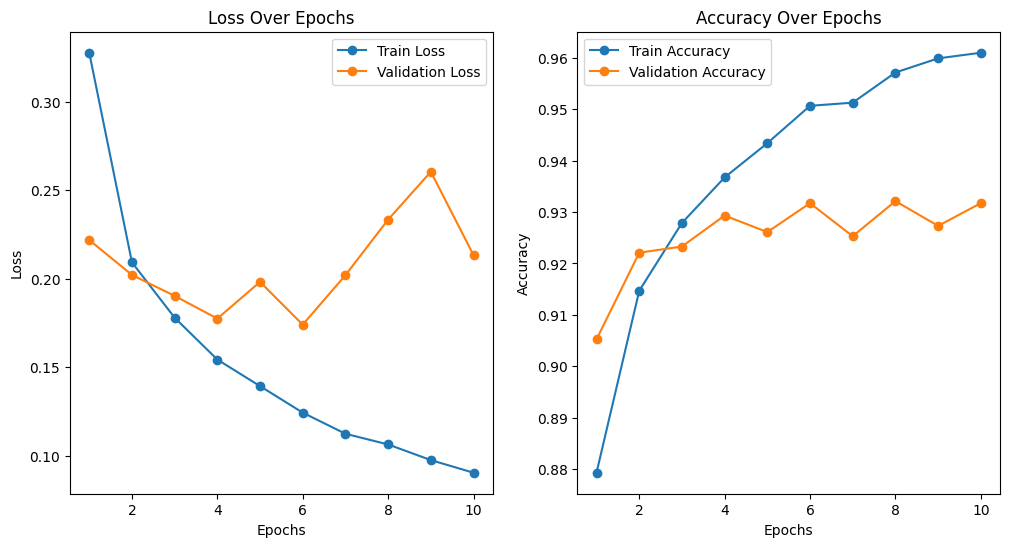

In [ ]:
import matplotlib.pyplot as plt

# Sample data for demonstration
tloss=train_loss_values
vloss=val_loss_values
tacc=train_acc_values
vacc=val_acc_values

# Plot loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, 11), tloss, label='Train Loss', marker='o')
plt.plot(range(1, 11), vloss, label='Validation Loss', marker='o')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, 11), tacc, label='Train Accuracy', marker='o')
plt.plot(range(1, 11), vacc, label='Validation Accuracy', marker='o')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


1/1 [==============================] - 0s 136ms/step


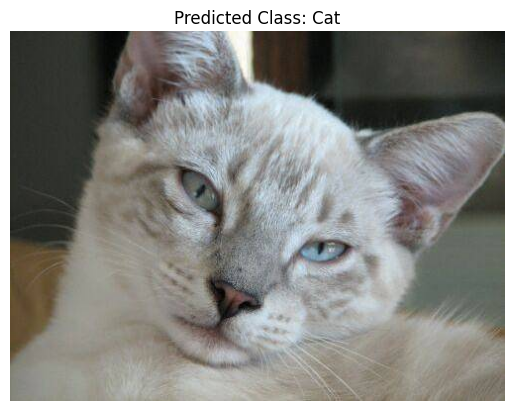

1/1 [==============================] - 0s 17ms/step


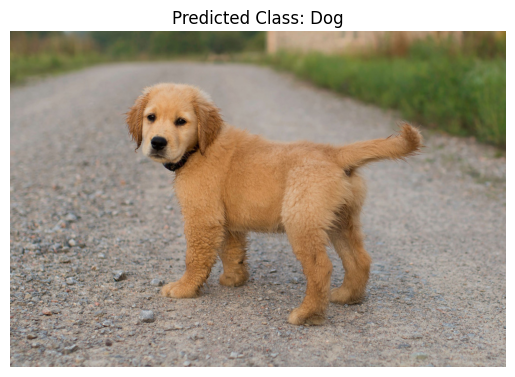

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import pickle
import matplotlib.pyplot as plt
from PIL import Image

def predict_image_class(image_path, model):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Rescale the image

    predictions = model.predict(img_array)
    if predictions[0, 0] > 0.5:
        return "Dog"
    else:
        return "Cat"

# Load your trained model
with open('vggmodel.pkl', 'rb') as file:
    model = pickle.load(file)

# List of image file paths
image_paths = [
    '/content/drive/MyDrive/dl/log/cat.jpg',
    '/content/drive/MyDrive/dl/log/puppy-dog.jpg',
]

# Process and predict the classes for each image in the list
for image_path in image_paths:
    predicted_class = predict_image_class(image_path, model)

    # Load and display the image
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted Class: {predicted_class}')
    plt.show()


# ***task3***

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self.make_layer(block, 64, layers[0])
        self.layer2 = self.make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self.make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self.make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

# Create a ResNet model
resnet = ResNet(ResidualBlock, [2, 2, 2, 2], num_classes=2)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


resnet = resnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # Adjust step_size and gamma as needed

# Training loop
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(15):
    print("epoch",epoch)
    resnet.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_dataloader:
        optimizer.zero_grad()
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        outputs = resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_dataloader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    resnet.eval()
    correct = 0
    total = 0
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in val_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = correct / total
    val_losses.append(val_loss / len(val_dataloader))
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch + 1}/{15}] - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy*100:.2f}%, Val Loss: {val_loss/len(val_dataloader):.4f}, Val Acc: {val_accuracy*100:.2f}")

    # Step the learning rate
    scheduler.step()


epoch 0
Epoch [1/15] - Train Loss: 0.5324, Train Acc: 73.61%, Val Loss: 0.6333, Val Acc: 68.03
epoch 1
Epoch [2/15] - Train Loss: 0.4704, Train Acc: 77.93%, Val Loss: 0.5042, Val Acc: 75.58
epoch 2
Epoch [3/15] - Train Loss: 0.4067, Train Acc: 81.78%, Val Loss: 0.3946, Val Acc: 81.16
epoch 3
Epoch [4/15] - Train Loss: 0.3564, Train Acc: 84.57%, Val Loss: 0.3526, Val Acc: 84.34
epoch 4
Epoch [5/15] - Train Loss: 0.3079, Train Acc: 86.82%, Val Loss: 0.3431, Val Acc: 84.50
epoch 5
Epoch [6/15] - Train Loss: 0.2234, Train Acc: 90.79%, Val Loss: 0.2636, Val Acc: 88.47
epoch 6
Epoch [7/15] - Train Loss: 0.2022, Train Acc: 91.64%, Val Loss: 0.2889, Val Acc: 87.63
epoch 7
Epoch [8/15] - Train Loss: 0.1909, Train Acc: 92.08%, Val Loss: 0.2663, Val Acc: 88.76
epoch 8
Epoch [9/15] - Train Loss: 0.1806, Train Acc: 92.57%, Val Loss: 0.2581, Val Acc: 88.92
epoch 9
Epoch [10/15] - Train Loss: 0.1692, Train Acc: 93.07%, Val Loss: 0.2779, Val Acc: 88.47
epoch 10
Epoch [11/15] - Train Loss: 0.1565, Trai

In [ ]:
# Test
resnet.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = correct / total

print(f"Test Accuracy: {test_accuracy * 100:.2f}")


Test Accuracy: 88.96


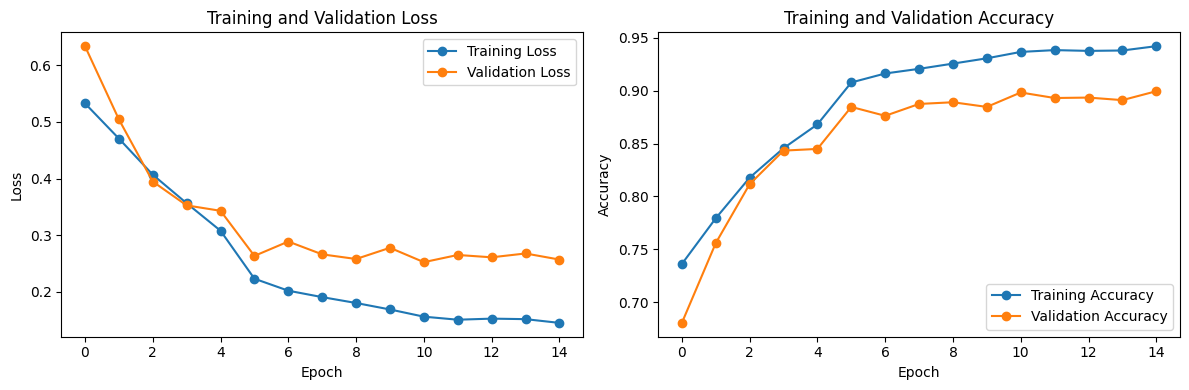

In [ ]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', marker='o', linestyle='-')
plt.plot(val_losses, label='Validation Loss', marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', marker='o', linestyle='-')
plt.plot(val_accuracies, label='Validation Accuracy', marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Show the plots
plt.tight_layout()
plt.show()



# ***task4***

In [ ]:
import torch
import torch.nn as nn


class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )

    def forward(self, x):
        x = self.encoder(x)
        return x

class BottleneckBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(BottleneckBlock, self).__init__()
        self.bottleneck = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.bottleneck(x)
        return x

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(out_channels * 2, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x, bridge):
        x = self.upconv(x)

        if x.shape[-2:] != bridge.shape[-2:]:
            bridge = F.interpolate(bridge, size=x.shape[-2:], mode='bilinear', align_corners=True)
        x = torch.cat([x, bridge], dim=1)  # Concatenate with the bridge (skip connection)
        x = self.conv1(x)
        x = self.conv2(x)
        return x


class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        # Encoder
        self.encoder = nn.ModuleList([
            EncoderBlock(in_channels, 64),
            EncoderBlock(64, 128),
            EncoderBlock(128, 256),
            EncoderBlock(256, 512)
        ])

        # Bottleneck
        self.bottleneck = BottleneckBlock(512, 1024)

        # Decoder
        self.decoder = nn.ModuleList([
            DecoderBlock(1024, 512),
            DecoderBlock(512, 256),
            DecoderBlock(256, 128),
            DecoderBlock(128, 64)
        ])

        # Output layer
        self.out = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        enc_features = []
        for encoder in self.encoder:
            x = encoder(x)
            enc_features.append(x)

        # Bottleneck
        x = self.bottleneck(x)

        # Decoder
        for i, decoder in enumerate(self.decoder):
            x = decoder(x, enc_features[-(i + 1)])

        # Output layer
        x = self.out(x)

        return x

unet = UNet(in_channels=3, out_channels=1)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(unet.parameters(), lr=0.001)


In [ ]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F  # Import torch.nn.functional

# ...
# Define the model, criterion, and optimizer
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

unet = UNet(in_channels=3, out_channels=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(unet.parameters(), lr=0.001)

# Set the number of training epochs
num_epochs = 10

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
# Training loop
train_losses4 = []
val_losses4 = []
train_accuracies4 = []  # Store training accuracies
val_accuracies4 = []  # Store validation accuracies

for epoch in range(num_epochs):
    print("Epoch", epoch)
    unet.train()
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, targets in train_dataloader:
        optimizer.zero_grad()
        images = images.to(device)
        outputs = unet(images)

        # Introduce label noise: Randomly flip labels with a probability
        noise_prob = 0.1  # Adjust this value as needed
        noisy_targets = torch.zeros(outputs.shape).to(device)
        for i in range(noisy_targets.size(0)):
            if random.random() < noise_prob:
                noisy_targets[i] = 1 - noisy_targets[i]

        targets = torch.zeros(outputs.shape).to(device)

        loss = criterion(outputs, noisy_targets)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

        predicted = (outputs > 0).float()  # Convert to binary predictions
        correct_train += (predicted == noisy_targets).sum().item()
        total_train += noisy_targets.numel()

    train_loss = running_train_loss / len(train_dataloader)
    train_accuracy = correct_train / total_train
    train_losses4.append(train_loss)
    train_accuracies4.append(train_accuracy)

    # Validation
    unet.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, targets in val_dataloader:
            images = images.to(device)
            outputs = unet(images)

            targets = torch.zeros(outputs.shape).to(device)

            loss = criterion(outputs, targets)
            running_val_loss += loss.item()

            predicted = (outputs > 0).float()  # Convert to binary predictions
            correct_val += (predicted == targets).sum().item()
            total_val += targets.numel()

    val_loss = running_val_loss / len(val_dataloader)
    val_accuracy = correct_val / total_val
    val_losses4.append(val_loss)
    val_accuracies4.append(val_accuracy)

    print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy * 100:.2f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy * 100:.2f}")

    scheduler.step()


Epoch 0
Epoch [1/10] - Train Loss: 6.6887, Train Acc: 89.54, Val Loss: 0.1097, Val Acc: 100.00
Epoch 1
Epoch [2/10] - Train Loss: 27664022.1785, Train Acc: 84.21, Val Loss: 17.7163, Val Acc: 98.53
Epoch 2
Epoch [3/10] - Train Loss: 484.1816, Train Acc: 81.33, Val Loss: 46.2467, Val Acc: 87.87
Epoch 3
Epoch [4/10] - Train Loss: 78794.1995, Train Acc: 80.79, Val Loss: 9.6215, Val Acc: 93.03
Epoch 4
Epoch [5/10] - Train Loss: 17.0312, Train Acc: 79.92, Val Loss: 1.8837, Val Acc: 93.26
Epoch 5
Epoch [6/10] - Train Loss: 3.5952, Train Acc: 82.01, Val Loss: 0.1641, Val Acc: 99.17
Epoch 6
Epoch [7/10] - Train Loss: 38.0680, Train Acc: 81.72, Val Loss: 0.0325, Val Acc: 99.99
Epoch 7
Epoch [8/10] - Train Loss: 182.2391, Train Acc: 82.09, Val Loss: 0.0524, Val Acc: 99.61
Epoch 8
Epoch [9/10] - Train Loss: 41.8775, Train Acc: 83.03, Val Loss: 0.0042, Val Acc: 99.95
Epoch 9
Epoch [10/10] - Train Loss: 1.1998, Train Acc: 86.57, Val Loss: 0.0797, Val Acc: 99.98


In [ ]:
unet.eval()

correct_test = 0
total_test = 0

with torch.no_grad():
    for images, targets in test_dataloader:
        images = images.to(device)
        outputs = unet(images)

        targets = torch.zeros(outputs.shape).to(device)

        predicted = (outputs > 0).float()
        correct_test += (predicted == targets).sum().item()
        total_test += targets.numel()

test_accuracy = correct_test / total_test
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Test Accuracy: 99.99%


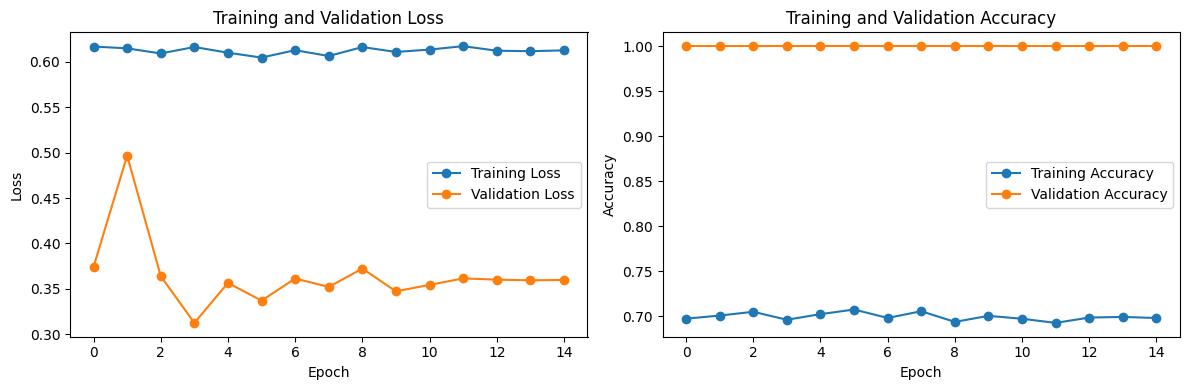

In [ ]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses4, label='Training Loss', marker='o', linestyle='-')
plt.plot(val_losses4, label='Validation Loss', marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies4, label='Training Accuracy', marker='o', linestyle='-')
plt.plot(val_accuracies4, label='Validation Accuracy', marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Show the plots
plt.tight_layout()
plt.show()
